In [1]:
import numpy as np
from seisLM.data_pipeline.foreshock_aftershock_dataset import (
  create_foreshock_aftershock_datasets
)
from seisLM.data_pipeline.foreshock_aftershock_dataloaders import (
  prepare_foreshock_aftershock_dataloaders)
import pandas as pd
import matplotlib.pyplot as plt
from seisLM.utils.project_path import gitdir

/scicore/home/dokman0000/liu0003/miniconda3/envs/seisbench_dgx/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json
import ml_collections
import torch
from seisLM.model.task_specific.foreshock_aftershock_models import (
  Conv1DShockClassifierLit, Wav2vec2ShockClassifierLit)

# model_relative_path = "/results/models/foreshock_aftershock_run/seisLM_base_shock_classifier_nc_9_frac_1.0_2024-09-10-14h-32m-11s/checkpoints/last.ckpt"
model_relative_path = "/results/models/foreshock_aftershock_run/seisLM_large_shock_classifier_nc_9_frac_1.0_2024-09-10-14h-34m-33s/checkpoints/last.ckpt"

model = Wav2vec2ShockClassifierLit.load_from_checkpoint(
  gitdir() + model_relative_path,
  load_pretrained=False
  )

In [3]:
def get_seisLM_config():
  config_path = gitdir() + '/seisLM/configs/foreshock_aftershock/seisLM_large_shock_classifier.json'
  with open(config_path, "r", encoding="utf-8") as f:
    config = json.load(f)
  config = ml_collections.ConfigDict(config)
  config.model_args.num_classes = model.model_config.num_classes
  return config

config = get_seisLM_config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
model = model.eval()
loaders = prepare_foreshock_aftershock_dataloaders(
  num_classes=config.model_args.num_classes,
  **config.data_args
)



Seed set to 42
Seed set to 42


In [4]:
iter_test = iter(loaders['test'])
input_values, y = next(iter_test)


<Figure size 800x800 with 0 Axes>

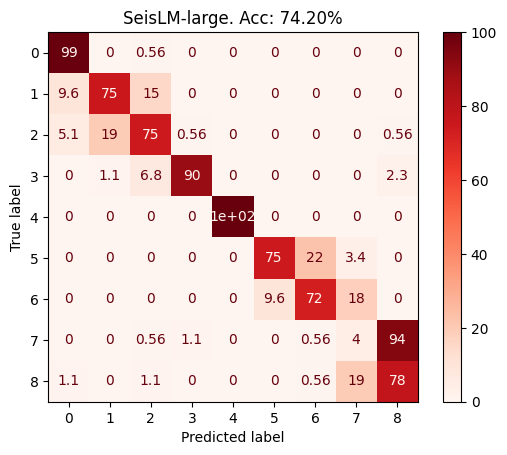

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


all_gt_class = []
all_pred_class = []
all_losses = []

model = model.to(device)
model.eval()

for X, y in loaders['test']:
  with torch.no_grad():
    logits = model(X.to(device)).cpu()
    pred_class = np.argmax(logits.numpy(), axis=1)
    loss = torch.nn.functional.cross_entropy(logits, y)
    all_losses.append(loss.item())

  all_gt_class.append(y)
  all_pred_class.append(pred_class)

all_gt_class = np.concatenate(all_gt_class)
all_pred_class = np.concatenate(all_pred_class)


cm = confusion_matrix(all_gt_class, all_pred_class)
cm_percentage = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
disp.plot(cmap='Reds')
if "base" in model_relative_path:
  plt.title("SeisLM-base. Acc: {:.2f}%".format(cm_percentage.diagonal().mean()))
elif "large" in model_relative_path:
  plt.title("SeisLM-large. Acc: {:.2f}%".format(cm_percentage.diagonal().mean()))
else:
  raise ValueError("model_relative_path must contain 'base' or 'large'")
# title = "SeisLM-base shock classifier" if "base" in model_relative_path else "SeisLM-large shock classifier"

In [6]:
cm_percentage.diagonal().mean()



74.19962335216573